### Preamble and Imports

* This notebook is modified notebooks originally developed in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html), although I've added some modification based on [Volodymyr Kuleshov's applied ML course](https://github.com/kuleshov/cornell-cs5785-2022-applied-ml)*

In [5]:
## Preamble / required packages
import numpy as np
import scipy.sparse as sp
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Supervised learning

+ For this course, we will see supervised learning as the process of learning a *generator* for a dataset: given a set of points, can we approximate the underlying process that produced those points?
+ + Forecasting: given some past values, predict future values
+ + Regression: Given a known generator with unknonw parameters (like a quadratic Hamiltonian with unknown amplitudes), infer those amplitudes
+ + Classification (most famous example in ML): Given examples of labelled images, states, etc, predict the class of unlabelled data. We can think of the learned decision boundary as defining a generator of new examples belonging to that class (see conditional GANs, etc)

## Linear Regression and the Ising Model

Consider the 1D Ising model with nearest-neighbor interactions 

$$H[\boldsymbol{S}]=-J\sum_{j=1}^L S_{j}S_{j+1}$$

on a chain of length $L$ with periodic boundary conditions and $S_j=\pm 1$ Ising spin variables. In one dimension, this paradigmatic model has no phase transition at finite temperature. 

For a more detailed introduction we refer the reader to consult one of the many textbooks on the subject (see for instance <a href="https://www.amazon.com/Lectures-Transitions-Renormalization-Frontiers-Physics/dp/0201554097">Goldenfeld</a>, <a href="https://www.google.com/search?q=lubensky+condensed+matter+physics&rlz=1C5CHFA_enCA776CA776&oq=lubensky+&aqs=chrome.2.69i57j0l5.3047j1j7&sourceid=chrome&ie=UTF-8">Lubensky</a>, <a href="https://physics.anu.edu.au/theophys/baxter_book.php">Baxter </a>, etc.).

### Learning the Ising model ###

Suppose you are performing an experiment on an unknown magnetic material. You observe a large number of spin configurations, and are able to compute their Ising energies. If you don't know the value of $J$ and thus the Hamiltonian, can you infer it given a data set of $i=1\ldots n$ points of the form $\{(H[\boldsymbol{S}^i],\boldsymbol{S}^i)\}$.

### Generate some data from a simulation 

+ In the real world, we won't have access to this generator. Here because we made our own data, we have a ground truth, or oracle, against which to compare our results.

In [6]:
### define Ising model parameters
# system size
L = 40



class IsingModel:
    """
    The Ising model with ferromagnetic interactions that encourage nearest neighbors
    to align
    """
    def __init__(self, L, random_state=None):
        self.L = L
        self.random_state = random_state

        self.J = np.zeros((L, L),)
        # Ferromagnetic interaction between nearest-neighbors
        for i in range(L):
            self.J[i, (i + 1) % L] = -1.0  # off first diagonal

    def sample(self, n_samples=1):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        return np.random.choice([-1, 1], size=(n_samples, self.L))

    def energy(self, state):
        return np.einsum("...i,ij,...j->...", states, self.J, states)

model_experiment = IsingModel(L)

# create 10000 random Ising states
states = model_experiment.sample(n_samples=10000)

# def ising_energies(states):
#     """
#     This function calculates the energies of the states in the nn Ising Hamiltonian
#     """
#     L = states.shape[1]
#     J = np.zeros(
#         (L, L),
#     )
#     for i in range(L):
#         J[i, (i + 1) % L] = -1.0  # interaction between nearest-neighbors

#     # compute energies

#     ## einsum is useful for contrations with high-rank tensors (common in data science)
#     E = np.einsum("...i,ij,...j->...", states, J, states)

#     return E


# calculate Ising energies
energies = model_experiment.energy(states)

print("Input data has shape: ", states.shape)
print("Labels have shape: ", energies.shape)

Input data has shape:  (10000, 40)
Labels have shape:  (10000,)


## Choosing the right model for the problem

First of all, we have to decide on a model class (possible Hamiltonians) we use to fit the data. In the absence of any prior knowledge, one sensible choice is the all-to-all Ising model

$$
H_\mathrm{model}[\boldsymbol{S}^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i.
$$
Notice that this model is uniquely defined by the non-local coupling strengths $J_{jk}$ which we want to learn. Importantly, this model is linear in ${\mathbf J}$ which makes it possible to use linear regression.

To apply linear regression, we would like to recast this model in the form
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$

where the vectors $\mathbf{X}^i$ represent all two-body interactions $\{S_{j}^iS_{k}^i \}_{j,k=1}^L$, and the index $i$ runs over the samples in the data set. To make the analogy complete, we can also represent the dot product by a single index $p = \{j,k\}$, i.e. $\mathbf{X}^i \cdot \mathbf{J}=X^i_pJ_p$. Note that the regression model does not include the minus sign, so we expect to learn negative $J$'s.

#### Our inductive bias

If we had known nothing at all about the generator of our data, we might have just passed the input spin vectors $\mathbf{S}$ as the inputs to our model. However, in this case we have prior knowledge that our Hamiltonian acts on nearest-neighbor interactions. Rather than leaving it to our model to figure this out, we can encode our "inductive bias" by feeding in training data that already has the form of a neighbor matrix



In [7]:
states = states[:, :, None] * states[:, None, :] # outer product creates neighbor matrix

# Data matrix / design matrix always has shape (n_samples, n_features)
X_all = np.reshape(states, (states.shape[0], -1)) 

# Match our labels
y_all = energies

In [9]:
y_all.shape

(10000,)

# Least squares fitting

Let's try training a linear model that maps our nearest-neighbor matrices to the predicted energy targets

In [10]:
# define number of samples
n_samples = 400

# define train and test data sets
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

Text(0, 0.5, 'Predicted energy (Training Data)')

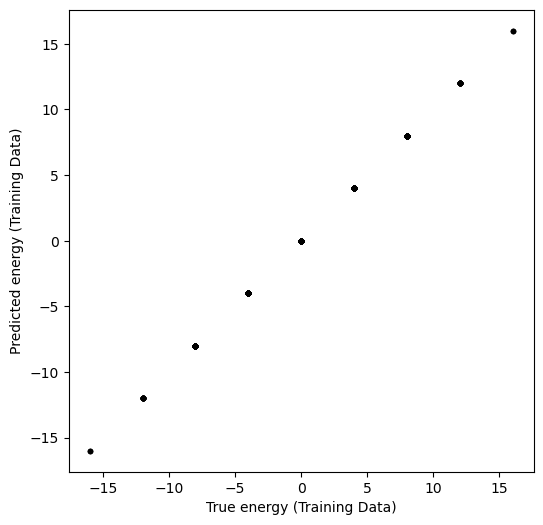

In [16]:
plt.figure(figsize=(6, 6))
plt.plot(y_train, y_pred_train, ".k")
plt.xlabel("True energy (Training Data)")
plt.ylabel("Predicted energy (Training Data)")


What about data that the model hasn't seen before?

Text(0, 0.5, 'Predicted energy (Test Data)')

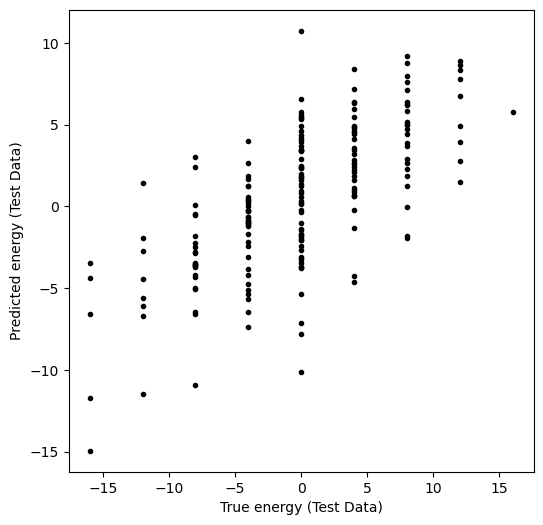

In [17]:
y_pred_test = model.predict(X_test)
# y_pred_test = model.predict(X_test)
plt.figure(figsize=(6, 6))
plt.plot(y_test, y_pred_test, ".k")
plt.xlabel("True energy (Test Data)")
plt.ylabel("Predicted energy (Test Data)")

Overfitting
+ High train accuracy just tells us that our model class is capable of expressing patterns found the training data
+ For all datasets, there exists a way to get 100% train accuracy as long as I have access to memory equal to the size of the trainin dataset (1-NN lookup table)
+ Need to either regularize (training data can't be perfectly fit) or use a test dataset to see how good our model actually is
+ A reasonable heuristic when choosing model complexity is to find one that can just barely overfit train (suggests suffcient power)

# Evaluating the performance

### Regression scoring: the coefficient of determination $R^2$

In what follows the model performance (in-sample and out-of-sample) is evaluated using the so-called coefficient of determination, which is given by:
\begin{align}
R^2 &= \left(1-\frac{u}{v}\right),\\
u&=(y_{pred}-y_{true})^2\\
v&=(y_{true}-\langle y_{true}\rangle)^2
\end{align}

The best possible score is 1.0 but it can also be negative. A constant model that always predicts the expected value of $y$, $\langle y_{true}\rangle$, disregarding the input features, would get a $R^2$ score of 0.

In [12]:
print("Train error was:", model.score(X_train, y_train))
print("Test error was:", model.score(X_test, y_test))

Train error was: 1.0
Test error was: 0.49574373554401063


## But raw score doesn't tell the whole story

+ We can get a great fit, but our model might have a lot of free parameters
+ There might be multiple valid coupling matrices $J$ that explain the observed data
+ Our model might be predictive but not interpretable, or physical
+ We either need more data, better data (sample rarer states), or a better model

Text(0.5, 1.0, 'Estimated coupling matrix $J$')

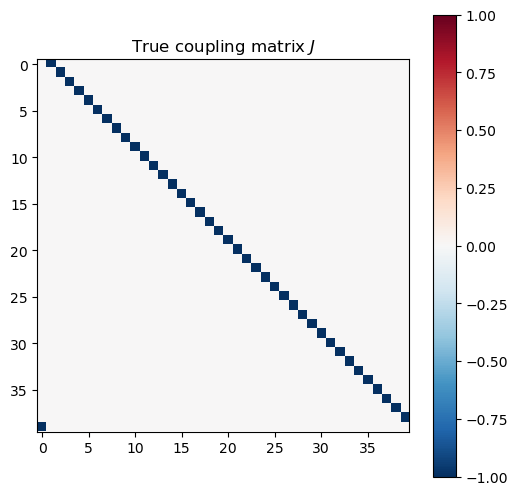

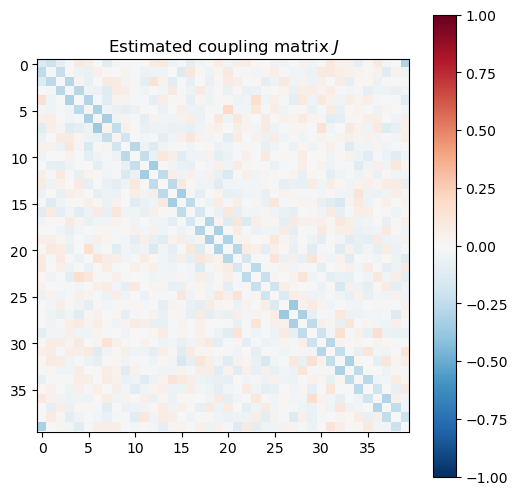

In [13]:
couplings_estimated = np.array(model.coef_).reshape((L, L))
couplings_true = model_experiment.J

plt.figure(figsize=(6, 6))
plt.imshow(couplings_true, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()
plt.title("True coupling matrix $J$")

plt.figure(figsize=(6, 6))
plt.imshow(couplings_estimated, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Estimated coupling matrix $J$")


# Regularization:

+ We constrain the model's allowed space of valid representations in order to select for more parsimonious models
+ Operationally, regularizers/constraints reduce the "effective" number of parameters, and thus complexity, of our model
+ Imposing preferred basis functions or symmetries can be forms of regularization
+ Can also help the model avoid looking at regions in representation space that are dead-ends, thus simplifying training

### Ridge regression and Lasso:

+ We can think of our least-squares problem as choosing the optimal $J$ that minimizes the following objective function, the mean squared error between the model energies and true energies
$$
\mathcal{L} = \sum_i (\mathbf{X}^(i) \cdot \mathbf{J}- H^(i))^2
$$
+ where $i$ indicates different training examples, which have predicted energies given by $\mathbf{X}^(i) \cdot \mathbf{J}$ and observed eenrgies of $H^(i)$
+ Ridge and Lasso common regularizers that act on the weights (trainable parameters) in our model
+ If $\mathbf{J}$ is our trainable linear regression weight matrix (and, in this context, our best estimate for the Ising interaction matrix), then the losses, or penalties, associated these regularizers have the following forms:
$$
\mathcal{L}_{Lasso} = \sum_{ij} | J_{ij} |
$$

$$
\mathcal{L}_{Ridge} = \sum_{ij} J_{ij}^2
$$

The ridge penalty (sometimes called $L2$ because of its functional form) discourages any particular weight in the coefficient matrix from becoming too large. Ridge is usually used when we want to impose a degree of smoothness or regularity across how a model treats its various inputs. Models that take continuous data as inputs (such as time series, or images), may benefit from the ridge term. In contrast, the Lasso or L1 penalty encourages sparsity in weight space: it incentivizes models were most coefficients go to zero, thereby reducing the models dependencies on features.

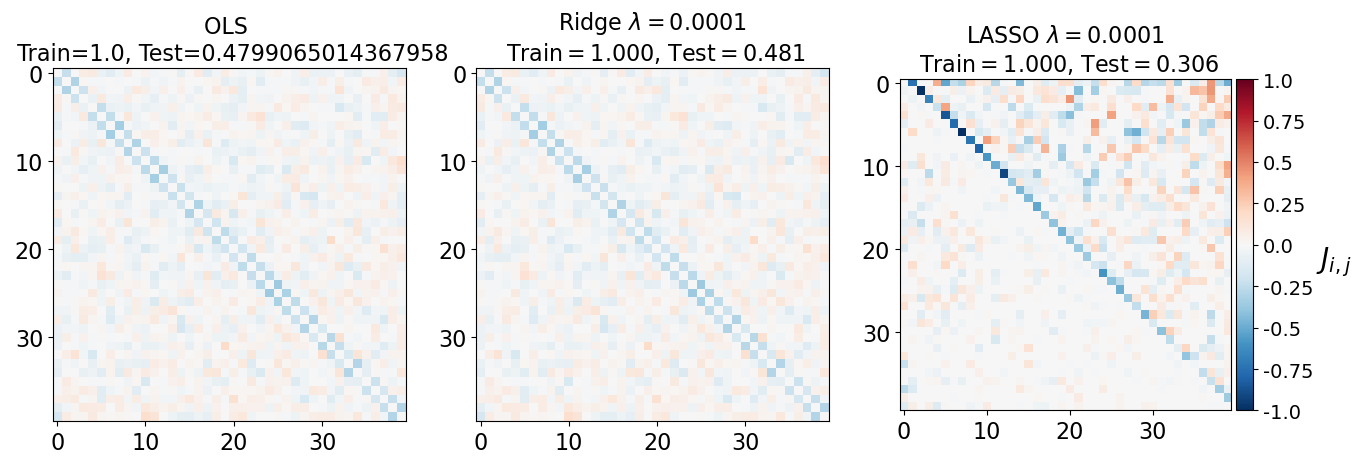

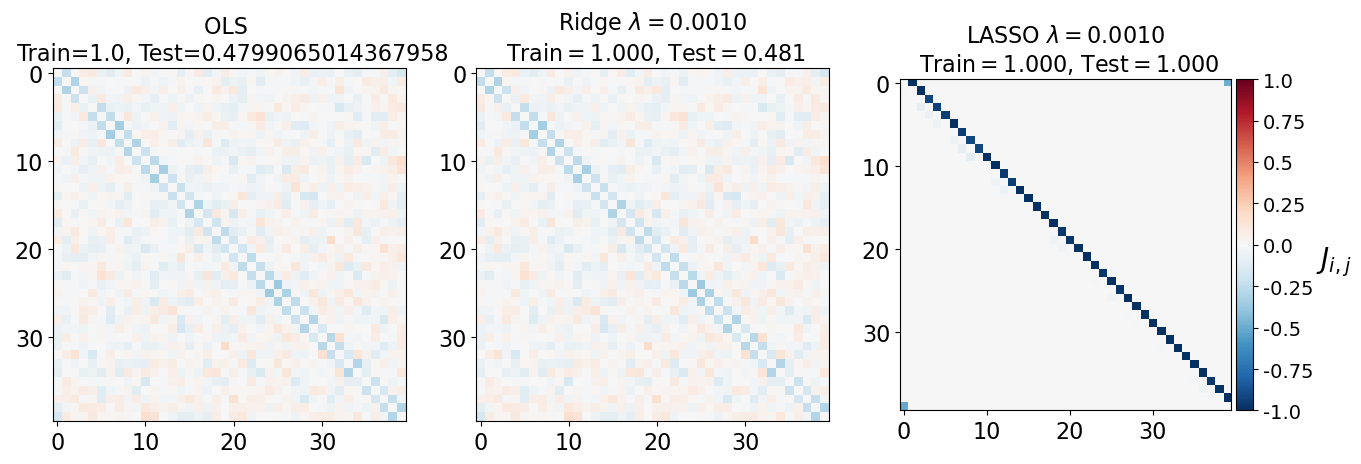

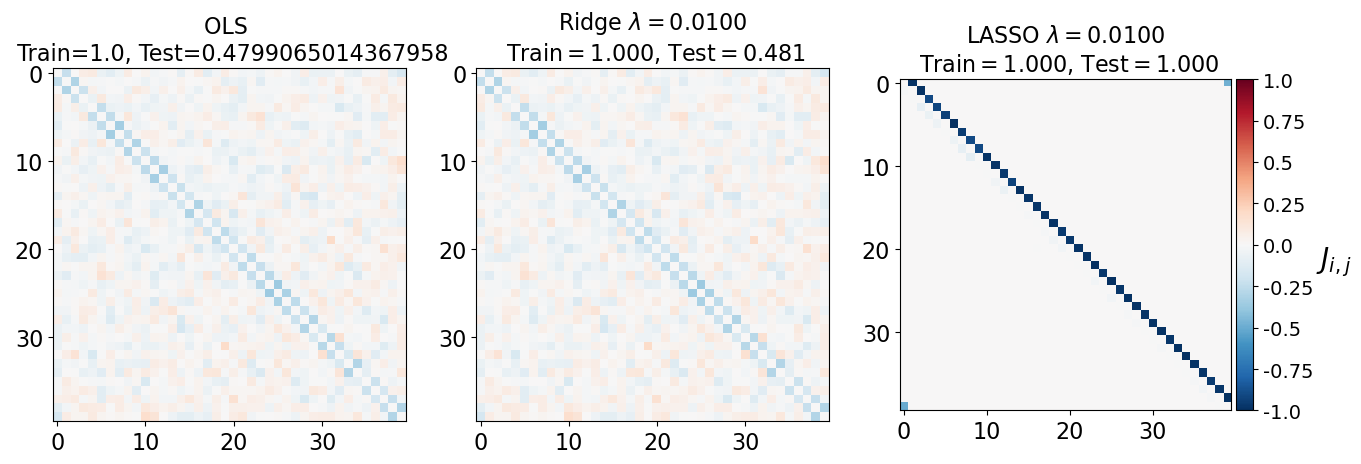

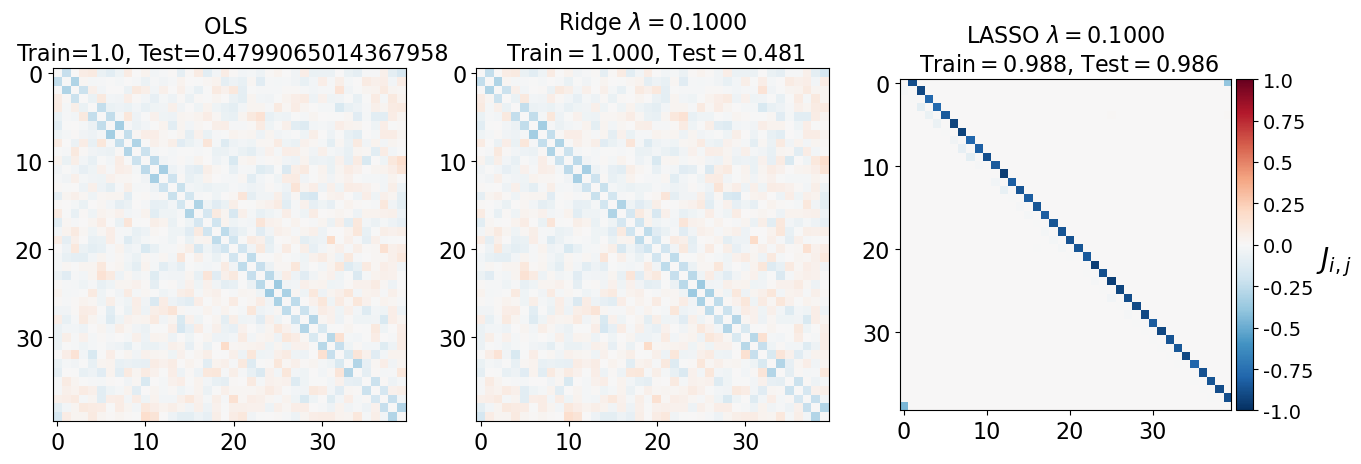

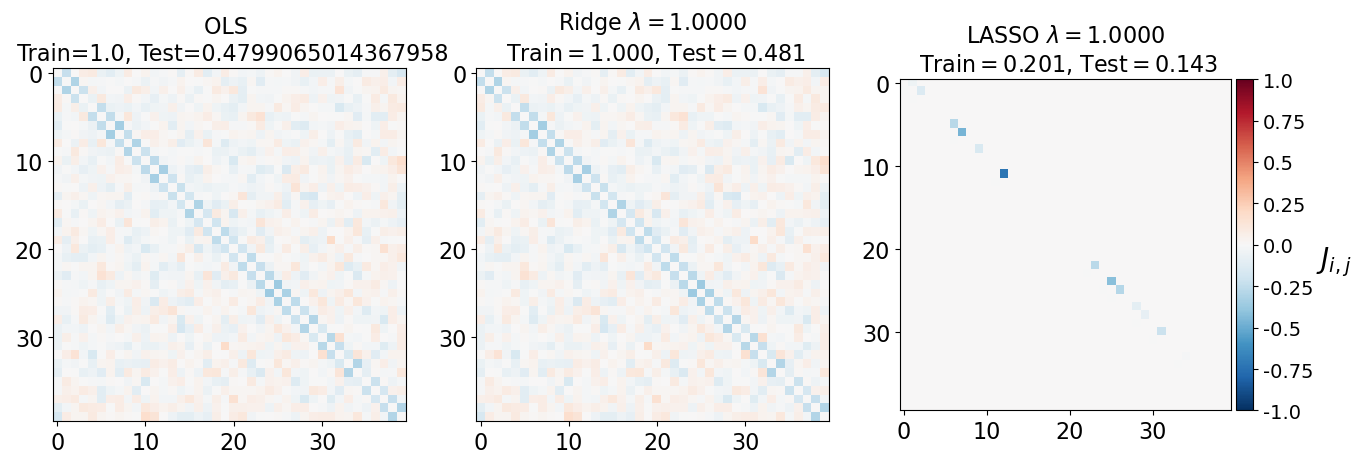

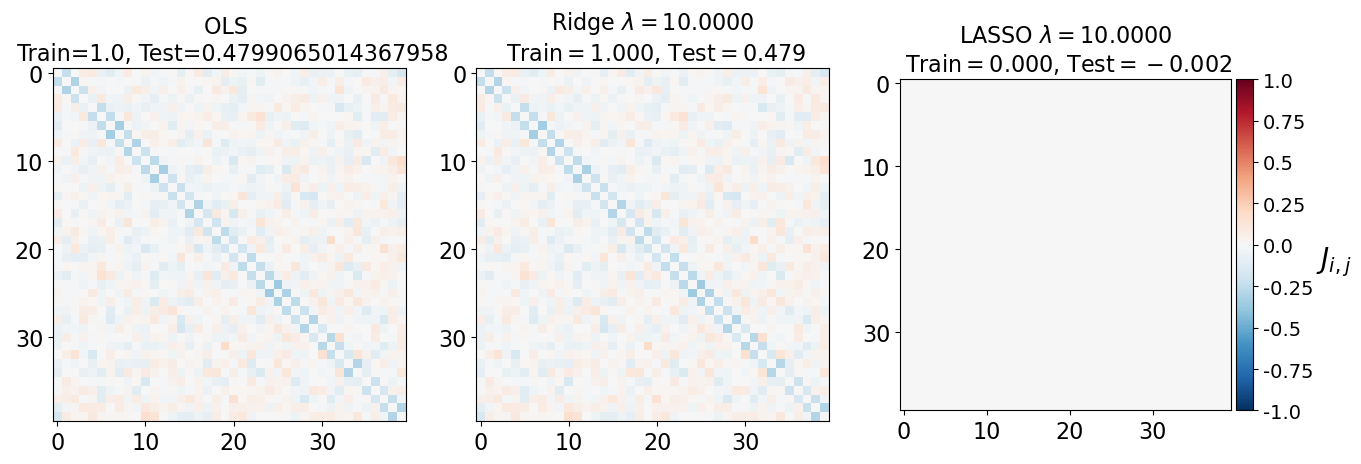

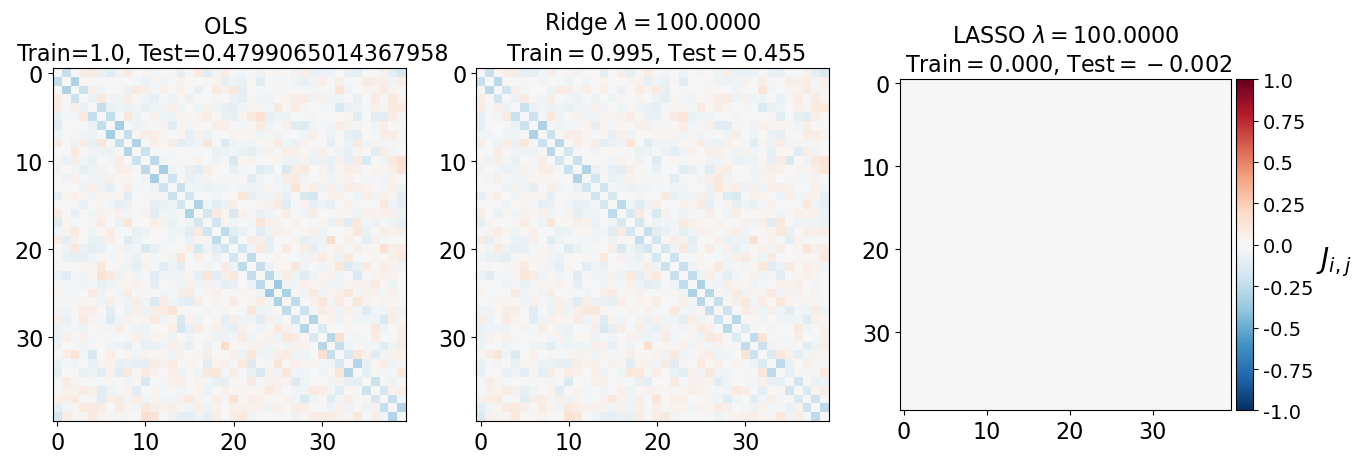

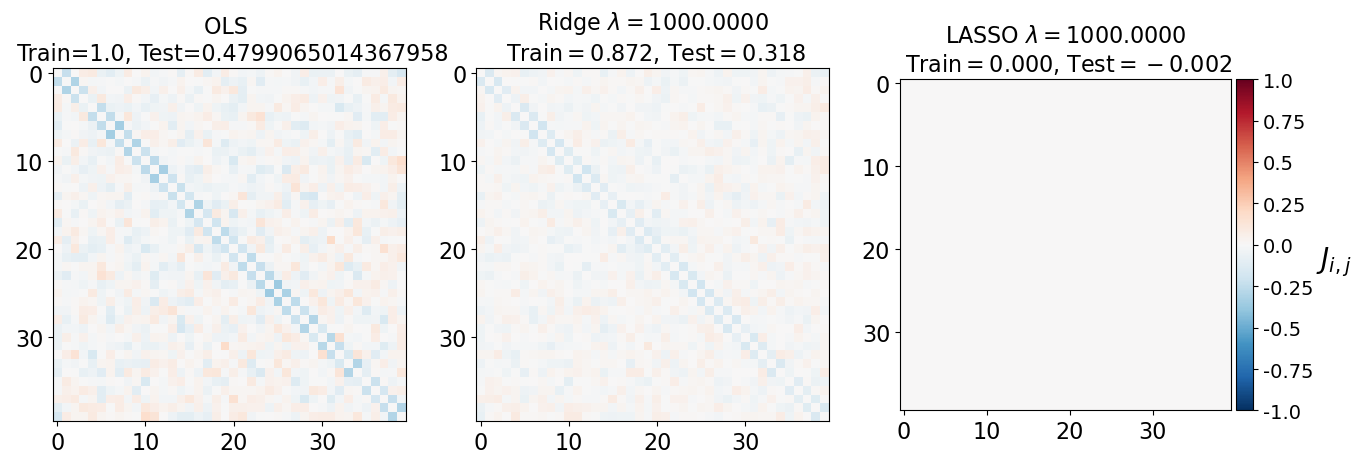

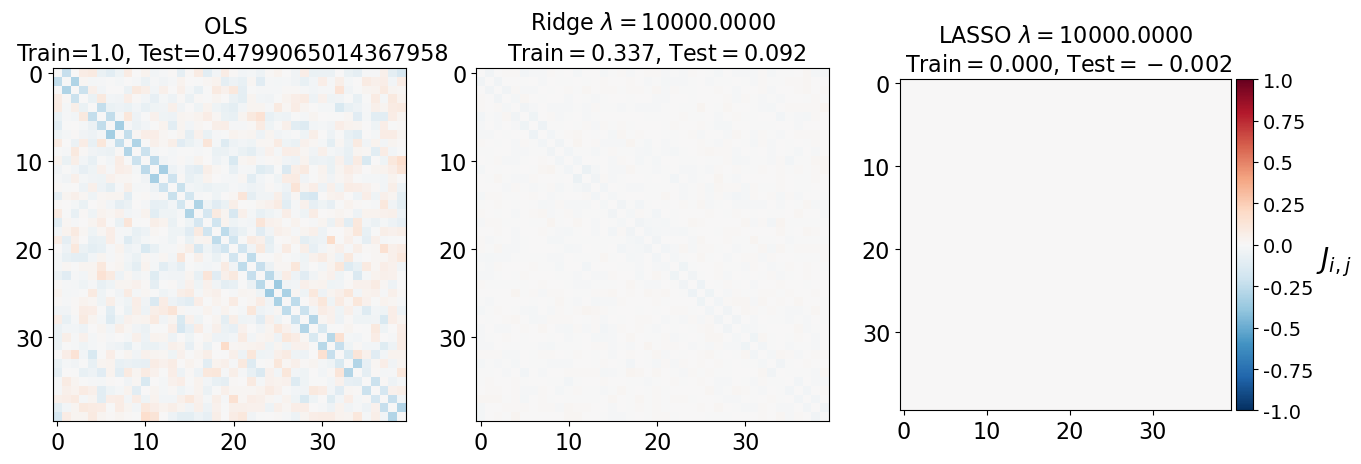

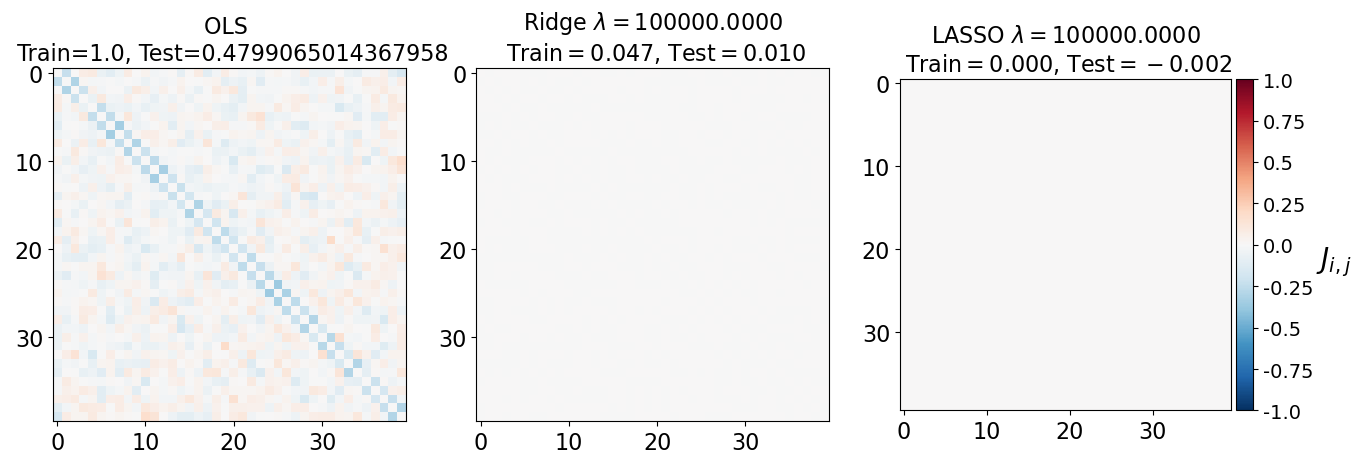

In [52]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
# leastsq = linear_model.LinearRegression()
# ridge = linear_model.Ridge()
# lasso = linear_model.Lasso()
model_ols = linear_model.LinearRegression()
model_l2 = linear_model.Ridge()
model_l1= linear_model.Lasso()

# set regularisation strength values
lambdas = np.logspace(-4, 5, 10)

# define error lists
train_error_ols, test_error_ols = list(), list()
train_error_l2, test_error_l2 = list(), list()
train_error_l1, test_error_l1 = list(), list()

#Initialize coefficients for ridge regression and Lasso
coeffs_ols, coeffs_ridge, coeffs_lasso = list(), list(), list()

for lam in lambdas:
    ### ordinary least squares
    model_ols.fit(X_train, y_train) # fit model 
    coeffs_ols.append(model_ols.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_error_ols.append(model_ols.score(X_train, y_train))
    test_error_ols.append(model_ols.score(X_test, y_test))

    ### ridge regression
    model_l2.set_params(alpha=lam) # set regularisation strength
    model_l2.fit(X_train, y_train) # fit model
    coeffs_ridge.append(model_l2.coef_) # store weights
    train_error_l2.append(model_l2.score(X_train, y_train))
    test_error_l2.append(model_l2.score(X_test, y_test))

    ### lasso
    model_l1.set_params(alpha=lam) # set regularisation strength
    model_l1.fit(X_train, y_train) # fit model
    coeffs_lasso.append(model_l1.coef_) # store weights
    train_error_l1.append(model_l1.score(X_train, y_train))
    test_error_l1.append(model_l1.score(X_test, y_test))




    ### plot Ising interaction J
    J_leastsq = np.array(model_ols.coef_).reshape((L, L))
    J_ridge = np.array(model_l2.coef_).reshape((L, L))
    J_lasso = np.array(model_l1.coef_).reshape((L, L))


    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[0].set_title(f"OLS \n Train={train_error_ols[-1]}, Test={test_error_ols[-1]}", fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l2[-1],test_error_l2[-1]),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso, cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l1[-1],test_error_l1[-1]),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

Text(0, 0.5, 'Performance $R^2$')

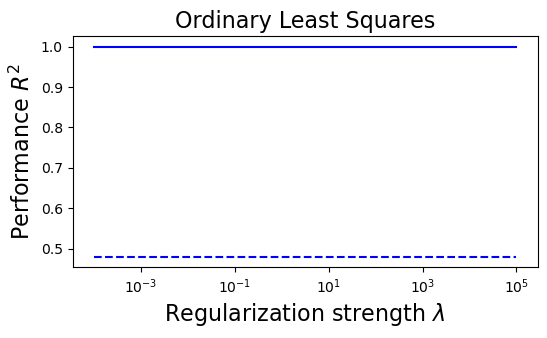

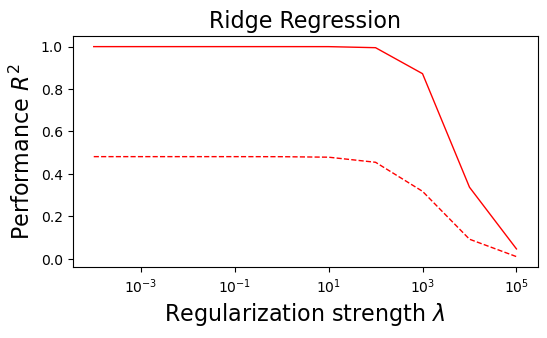

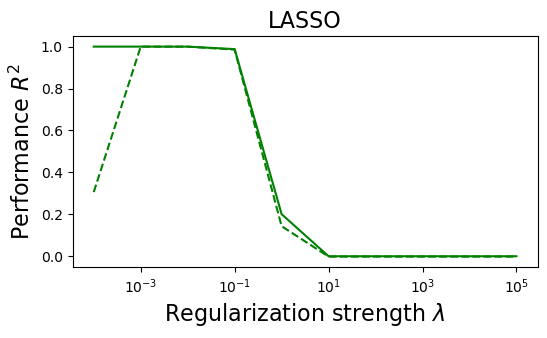

In [63]:
# Plot our performance on both the training and test data
plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_ols, "b", label="Train (OLS)")
plt.semilogx(lambdas, test_error_ols, "--b", label="Test (OLS)")
plt.title("Ordinary Least Squares", fontsize=16)
plt.xlabel("Regularization strength $\lambda$", fontsize=16)
plt.ylabel("Performance $R^2$", fontsize=16)


plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l2, "r", label="Train (Ridge)", linewidth=1)
plt.semilogx(lambdas, test_error_l2, "--r", label="Test (Ridge)", linewidth=1)
plt.title("Ridge Regression", fontsize=16)
plt.xlabel("Regularization strength $\lambda$", fontsize=16)
plt.ylabel("Performance $R^2$", fontsize=16)

plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l1, "g", label="Train (LASSO)")
plt.semilogx(lambdas, test_error_l1, "--g", label="Test (LASSO)")
plt.title("LASSO", fontsize=16)
plt.xlabel("Regularization strength $\lambda$", fontsize=16)
plt.ylabel("Performance $R^2$", fontsize=16)


### Understanding the results


(i) at $\lambda\to 0$ and $\lambda\to\infty$, all three models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity. 

(ii) While the OLS and Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO regularization parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbor terms (as did the model the data was generated from).

__Gauge degrees of freedom__: recall that the uniform nearest-neighbor interactions strength $J_{j,k}=J$ which we used to generate the data was set to unity, $J=1$. Moreover, $J_{j,k}$ was NOT defined to be symmetric (we only used the $J_{j,j+1}$ but never the $J_{j,j-1}$ elements). The colorbar on the matrix elements plot above suggest that the OLS and Ridge regression learn uniform symmetric weights $J=-0.5$. There is no mystery since this amounts to taking into account both the $J_{j,j+1}$ and the $J_{j,j-1}$ terms, and the weights are distributed symmetrically between them. LASSO, on the other hand, can break this symmetry (see matrix elements plots for $\lambda=0.001$ and $\lambda=0.01$). Thus, we see how different regularization schemes can lead to learning equivalent models but in different gauges. Any information we have about the symmetry of the unknown model that generated the data has to be reflected in the definition of the model and the regularization chosen.

# Hyperparameters

We can imagine that an even more general model would have both regularizers, each with different strengths
$$
\mathcal{L}_{total} = \mathcal{L}_{least-squares} + \lambda_1 \mathcal{L}_{lasso} + \lambda_2 \mathcal{L}_{ridge}
$$
This loss function is sometimes referred to as least-squares with an ElasticNet penalty.


## Why not always use regularizers
+ The issue: we have two arbitrary factors, $\lambda_1$ and $\lambda_2$, which determine how important the L1 and L2 penalties are relative to the primary fitting. These change the available solution space and thus model class
+ These are not "fit" during training like ordinary parameters; rather they are specified beforehand, perhaps with a bit of intuition or domain knowledge, These therefore represent *hyperparameters* of the model
+ Generally speaking, any "choices" we make---amount of data, model type, model parameters, neural network depth, etc are all hyperparameters. How do we choose these in a principled manner?
+ A major question in machine learning: **How do we choose the best hyperparameters for a model?**



## Validation set
+ Hold out some data just for hyperparameter tuning, separate from the test set
+ Don't validate on test, that leads to data leakage and thus overfitting

Best lambda on validation set 0.005623413251903491


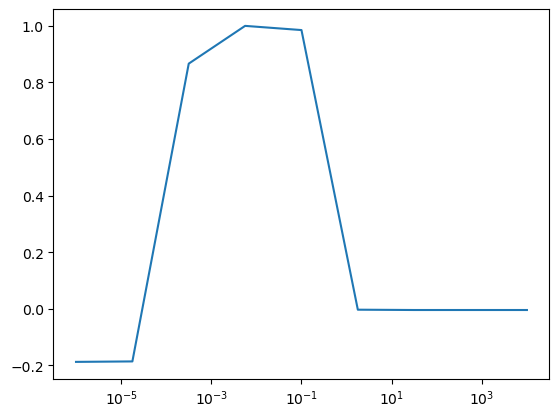

In [37]:
from sklearn import linear_model

# define train, validation and test data sets
X_train, X_val, X_test = X_all[:400], X_all[400 : 600], X_all[600 : 800]
y_train, y_val, y_test = y_all[:400], y_all[400 : 600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 9)

all_validation_losses = list()

for lam in lambdas:
    model_l1 = linear_model.Lasso(alpha=lam)
    model_l1.fit(X_train, y_train)
    validation_loss = model_l1.score(X_val, y_val)
    all_validation_losses.append(validation_loss)

best_lambda = lambdas[np.argmax(all_validation_losses)]

plt.semilogx(lambdas, all_validation_losses, label="Validation")

print("Best lambda on validation set", best_lambda)

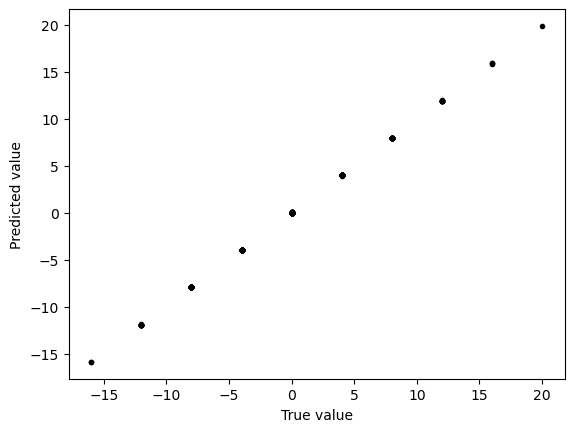

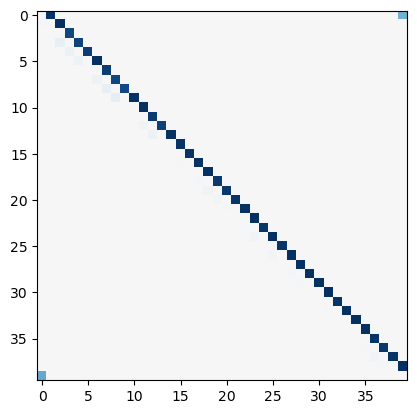

In [49]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)

## Cross-validation

+ We repeatedly split-up the train into multiple sub-splits for training and validation
+ For example, if we have 100 train points, we can create five 80:20 "splits", and average the best hyperparameter across the splits
+ If we perform $k$ subsplits, we refer to our procedure as k-fold cross-validation
+ More elaborate splitting methods (random Monte Carlo, importance weighted, etc)

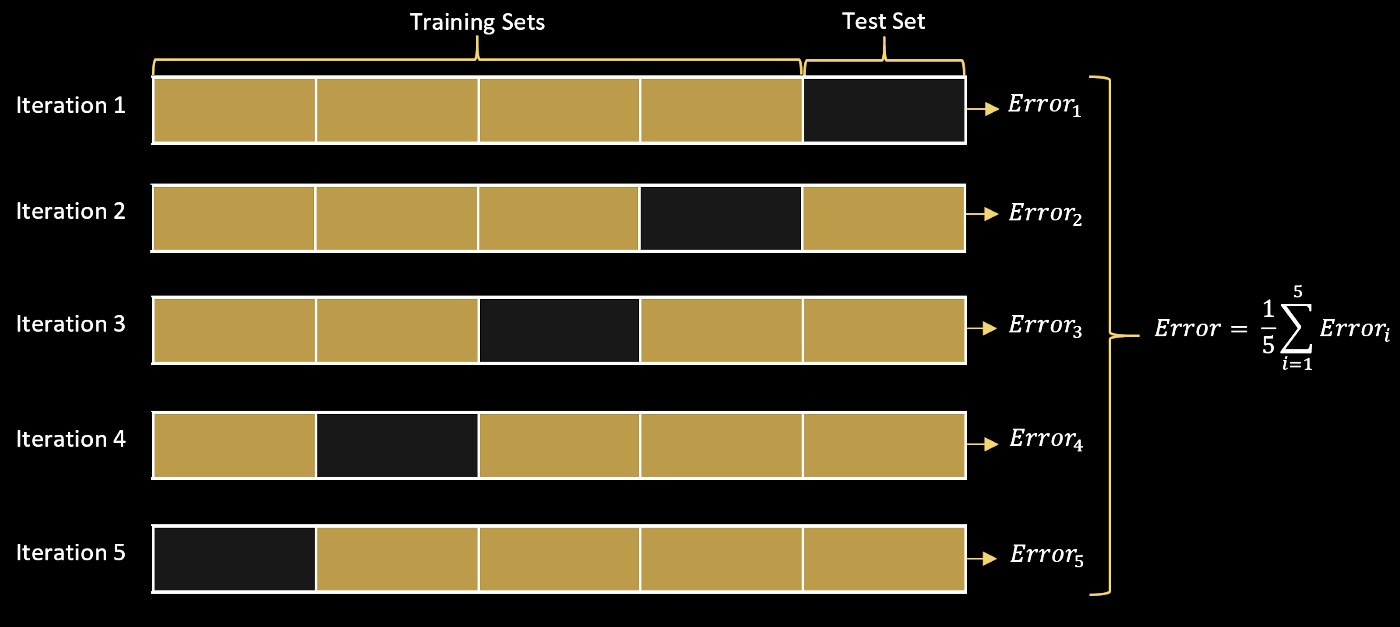

In [4]:
Image("../resources/cross_val.png", width=1000)
# https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b

Best lambda on validation set 0.005623413251903491


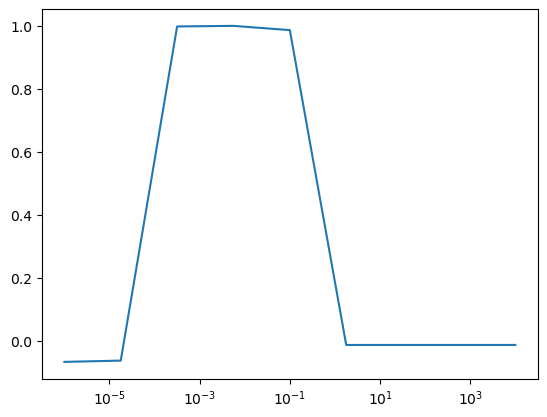

In [65]:
## Cross validation

from sklearn import linear_model

# define train, validation and test data sets
X_train, X_test = X_all[:600], X_all[600 : 800]
y_train, y_test = y_all[:600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 9)

all_validation_losses = list()

for lam in lambdas:

    all_val_loss_lam = list()

    for k in range(5):

        # Create the training and validation subsets from the training data
        X_train_k = np.concatenate([X_train[:k*100], X_train[(k+1)*100:]])
        y_train_k = np.concatenate([y_train[:k*100], y_train[(k+1)*100:]])
        X_val_k = X_train[k*100:(k+1)*100]
        y_val_k = y_train[k*100:(k+1)*100]


        model_l1 = linear_model.Lasso(alpha=lam)
        model_l1.fit(X_train_k, y_train_k)
        validation_loss = model_l1.score(X_val_k, y_val_k)
        all_val_loss_lam.append(validation_loss)

    all_validation_losses.append(np.mean(all_val_loss_lam))

best_lambda = lambdas[np.argmax(all_validation_losses)]
plt.figure()
plt.semilogx(lambdas, all_validation_losses, label="Validation")
print("Best lambda on validation set", best_lambda)

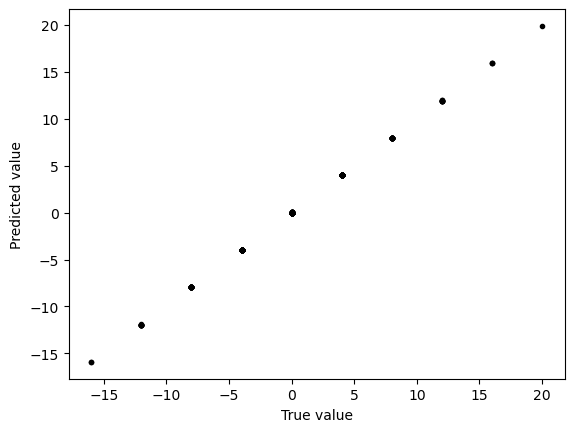

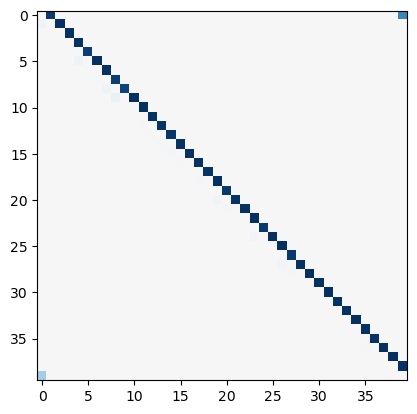

In [66]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)